In [1]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

from utils import *
from src import *

2024-11-23 12:39:45.438240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 12:39:45.449770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732361985.465289   17439 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732361985.469514   17439 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 12:39:45.484601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
model = models.resnet50(pretrained=True)
class_names = np.loadtxt('imagenet_classes.txt', str, delimiter='\t')

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


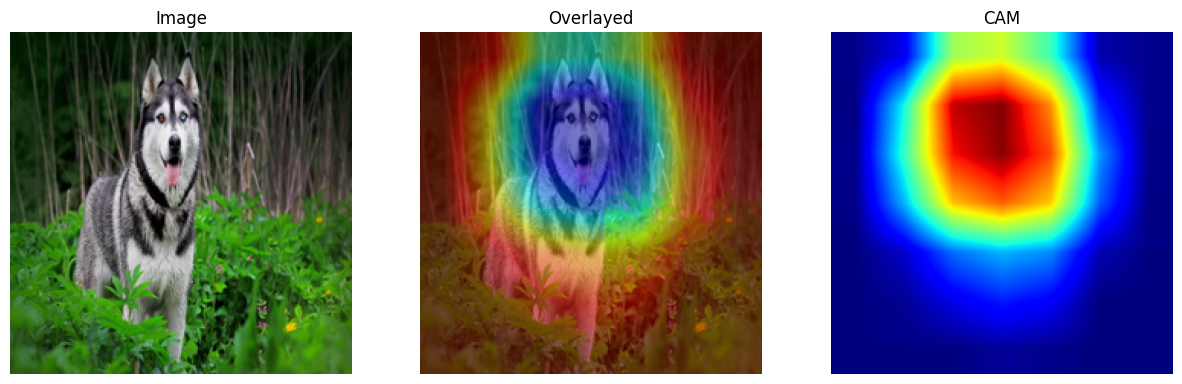

In [3]:
img = get_image_torch('images/husky.jpg', 224, 224)
cam = get_hirescam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam, 0.5)

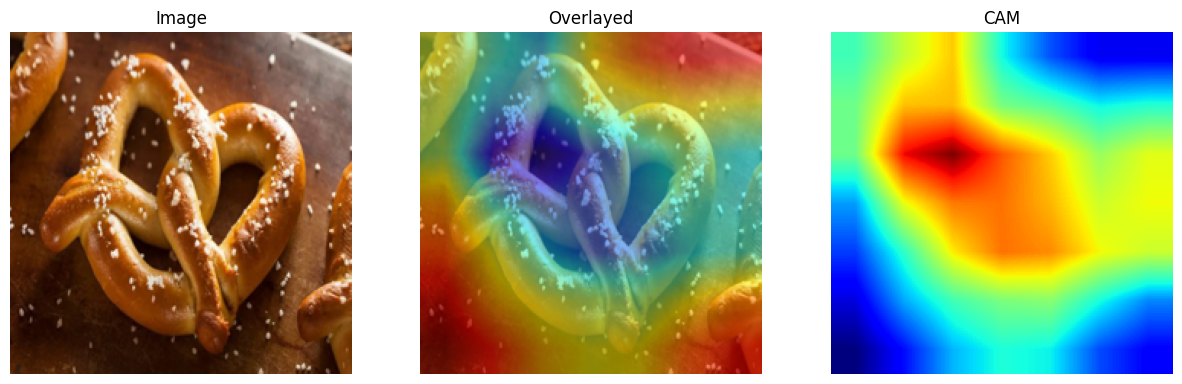

In [4]:
img = get_image_torch('images/precelek.jpg', 224, 224)
cam = get_hirescam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam, 0.5)